## 머신러닝1
어느 도시의 2가지 노선의 버스들의 승객 탑승 데이터이다.
동일 노선을 운행하는 버스는 동일한 정류장을 순차적으로 이동한다.    
승객타입은 청소년, 성인, 노인 3타입이며 청소년 요금은 1천원, 성인은 2천원, 노인은 500원이다.

In [3]:
import pandas as pd
df = pd.read_csv('./m1.csv')
df.head()

,노선ID,버스ID,정류장ID,일시,인원수,승객타입,행동타입
0,노선1,VEM7J0rb5O,1,2025-01-01 05:00:00,0,청소년,탑승
1,노선1,VEM7J0rb5O,2,2025-01-01 05:03:57,0,청소년,탑승
2,노선1,VEM7J0rb5O,3,2025-01-01 05:07:09,0,청소년,탑승
3,노선1,VEM7J0rb5O,4,2025-01-01 05:16:28,0,청소년,탑승
4,노선1,VEM7J0rb5O,5,2025-01-01 05:21:48,0,청소년,탑승


In [8]:
# df.describe(include='all') # include = 'O'

## 머신러닝1-1
아래의 기준으로 데이터 전처리를 시행하라.

1. 승객타입 컬럼의 unique value들을 컬럼으로 만들고 인원수를 value로 삽입하라. 결측치가 있다면 0으로 만든다
2. 노선ID,버스ID,정류장ID,일시에 대해 누적청소년,누적성인,누적노인 인원수 컬럼을 생성하라. 
3. 노선ID,버스ID,정류장ID,일시에 대해 누적수익 컬럼을 만들고 누적 수익금액을 계산하라
4. 정류장간 이동시간 컬럼(초단위)을 생성하라. 첫번째 정류장까지의 이동시간은 31초로 고정이다.
5. 날짜 관련한 파생변수를 3개 추가하라

In [95]:
pdf = pd.pivot(data=df , index =['노선ID','버스ID','정류장ID','일시','행동타입'],columns =['승객타입'],values = '인원수')
pdf = pdf.reset_index()
pdf = pdf.sort_values(['노선ID','일시','버스ID','정류장ID']).reset_index(drop=True)
pdf = pdf.fillna(0)
pdf.columns.name = ''


# 2,3번 전처리 순서 
# 1. 탑승에 대해 수익계산  / 청소년 요금은 1천원, 성인은 2천원, 노인은 500원
# 2. 하차 인원 음수 변경
# 3. 탑승,하차 groupby().sum()
# 4. 고정 컬럼으로 groupby() .cumsum()

# method1
# pdf.loc[pdf['행동타입'] =='탑승','수익'] = pdf[['노인','성인','청소년']]\
# .apply(lambda x : x['노인'] *500 + x['성인'] *2000 + x['청소년'] * 1000,axis=1)
# pdf['수익'] = pdf['수익'].fillna(0)

# method2
pdf.loc[:,'수익'] = pdf[['노인','성인','청소년']]\
.apply(lambda x : x['노인'] *500 + x['성인'] *2000 + x['청소년'] * 1000,axis=1)
pdf.loc[pdf['행동타입'] =='하차','수익'] = 0

# 2-
pdf.loc[pdf['행동타입'] =='하차',['노인','성인','청소년','수익']] = -pdf.loc[pdf['행동타입'] =='하차',['노인','성인','청소년','수익']]

# 3
gpdf = pdf.groupby(['노선ID','버스ID','정류장ID','일시'])[['노인','성인','청소년','수익']].sum().reset_index()

# 4
cumcumdf = gpdf.groupby(['노선ID','버스ID'])[['노인','성인','청소년','수익']].cumsum()
gpdf.loc[:,['누적노인','누적성인','누적청소년','누적수익']] = cumcumdf.values

gpdf = gpdf.drop(columns =['노인','성인','청소년','수익'])
gpdf

,노선ID,버스ID,정류장ID,일시,누적노인,누적성인,누적청소년,누적수익
0,노선1,04p7d5Nsf2,1,2025-01-04 21:13:00,5.0,5.0,0.0,12500.0
1,노선1,04p7d5Nsf2,2,2025-01-04 21:16:57,5.0,6.0,0.0,16500.0
2,노선1,04p7d5Nsf2,3,2025-01-04 21:20:09,5.0,6.0,0.0,18500.0
3,노선1,04p7d5Nsf2,4,2025-01-04 21:29:28,5.0,8.0,0.0,28500.0
4,노선1,04p7d5Nsf2,5,2025-01-04 21:34:48,5.0,9.0,0.0,34500.0
...,...,...,...,...,...,...,...,...
207503,노선2,zzaCF1JL2A,38,2025-01-20 01:53:08,3.0,22.0,7.0,222500.0
207504,노선2,zzaCF1JL2A,39,2025-01-20 01:59:09,6.0,21.0,4.0,224000.0
207505,노선2,zzaCF1JL2A,40,2025-01-20 02:03:56,6.0,25.0,4.0,234000.0
207506,노선2,zzaCF1JL2A,41,2025-01-20 02:12:39,6.0,26.0,3.0,236000.0


In [104]:
gpdf['일시'] =pd.to_datetime(gpdf['일시'])

In [107]:
pd.set_option('display.max_rows',200)

In [114]:
gpdf['diff_time'] = gpdf.groupby(['노선ID',	'버스ID'])['일시'].diff().dt.total_seconds().fillna(31)

In [119]:
gpdf['weekday'] = gpdf['일시'].dt.weekday
gpdf['hour'] = gpdf['일시'].dt.hour
gpdf['minute'] = gpdf['일시'].dt.minute

In [212]:
################### 다른분 풀이 ####################

df.loc[df['행동타입']=='하차','인원수']= df['인원수']*-1
pivot_df = df.pivot_table(index=['노선ID','버스ID','정류장ID','일시'],columns=['승객타입'],values='인원수',aggfunc='sum'
              ).reset_index().sort_values(by=['노선ID','일시'])

pivot_df[['노인','성인','청소년']] = pivot_df.groupby(['노선ID','버스ID'])[['노인','성인','청소년']].cumsum()
pivot_df.reset_index(drop=True,inplace=True)

#################################################

## 머신러닝 1-2
전처리한 데이터를 기준으로 EDA를 실시하라.(시각화, 기술통계량)

In [161]:
# 일자별 최종 수익

In [135]:
t = gpdf.groupby(['노선ID','버스ID']).tail(1)[['노선ID','일시','누적수익']]
t['date'] = t['일시'].dt.date
t= t.drop(columns =['일시'])
gt = t.groupby(['노선ID','date']).sum().reset_index()


In [151]:
import koreanize_matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

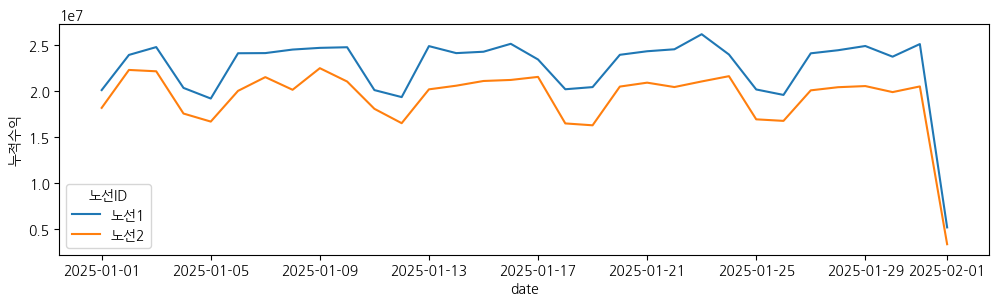

In [160]:
gt = t.groupby(['노선ID','date']).sum().reset_index()

fig,ax = plt.subplots(figsize=(12,3))
sns.lineplot(data = gt,x = 'date',y='누적수익',hue='노선ID',ax=ax)
plt.show()

## 머신러닝 1-3
- 하나의 버스가 모든 정류소를 돌았을 때 벌어들일 수익을 예측하는 회귀 모델을 만들려고 한다. 
- 하나의 버스가 출행한 정보로 다양한 독립변수(+파생변수)를 구성하고 최종 누적 금액을 종속변수로 한다. 
- 독립변수에는 청소년과 성인 승하차로 발생한 데이터는 사용할 수 없다. 노인의 데이터만 사용한다
- 최종적으로 4510행의 데이터로 변환
- 평가지표는 mse로 한다. 
- 15시 이전에 출발을 시작한 데이터를 train, 그 외 데이터를 test로 한다.
- 2가지 이상의 모델을 사용하며 모델결과분석을 진행하라

In [ ]:
# 한 정류장에서 최대 노인 탑승 수 / 한 정류장에서 최대 노인 하차 수
max_b = pdf[pdf.행동타입 =='탑승'].groupby(['노선ID','버스ID'])['노인'].max()
max_a = - pdf[pdf.행동타입 =='하차'].groupby(['노선ID','버스ID'])['노인'].min()

# 누적 탑승 노인 수
total_ = pdf[pdf.행동타입 =='탑승'].groupby(['노선ID','버스ID'])['노인'].sum()

# 버스 출발 시간대 (hour) ,주말여부
st = pdf[pdf.정류장ID ==1].drop_duplicates(['노선ID','버스ID'])[['노선ID','버스ID','일시']]
st['일시'] = pd.to_datetime(st['일시'])
st['출발시간대']  = st['일시'].dt.hour
st['주말여부']  = st['일시'].dt.weekday.map(lambda x : 1 if x in [5,6] else 0)

# 종속변수 누적수익
y = gpdf.groupby(['노선ID','버스ID'])[['노선ID','버스ID','누적수익']].tail(1).set_index(['노선ID','버스ID'])

model_df = pd.concat([max_b,max_a,total_,st.set_index(['노선ID','버스ID']),y],axis=1)
model_df.columns =['최대탑승노인','최대하차노인','누적탑승노인','일시','출발hour','주말여부','누적수익']
model_df = model_df.drop(columns =['일시'])
model_df['type'] = model_df['출발hour'].map(lambda x : 'train' if x <15 else 'test')

모델링은 랜포와 LinearRegression 두개를 비교(극단적인 결과를 얻기 위해)
랜포의 변수중요도까지 해서 풀어서 정리하기

## 통계1
10명의 환자들에게 3가지 치료법으로 치료했을 때 결과데이터이다. 세 치료법 간 효과 차이가 존재하는지 통계검정을 수행하려한다.     
귀무가설과 대립가설을 설정하고 근거를 들어 통계검정방식을 결정한 후 결과를 도출하라

In [218]:
import pandas as pd
df = pd.read_csv('./s1.csv')
df

,환자,치료법1,치료법2,치료법3
0,환자1,효과있음,효과없음,효과있음
1,환자2,효과없음,효과있음,효과없음
2,환자3,효과있음,효과있음,효과있음
3,환자4,효과없음,효과없음,효과없음
4,환자5,효과있음,효과있음,효과없음
5,환자6,효과없음,효과없음,효과있음
6,환자7,효과있음,효과있음,효과있음
7,환자8,효과없음,효과없음,효과없음
8,환자9,효과있음,효과없음,효과있음
9,환자10,효과없음,효과있음,효과없음


In [219]:
dic = {'효과있음':1,'효과없음':0}
df['치료법1'] = df['치료법1'].map(dic)
df['치료법2'] = df['치료법2'].map(dic)
df['치료법3'] = df['치료법3'].map(dic)
df

,환자,치료법1,치료법2,치료법3
0,환자1,1,0,1
1,환자2,0,1,0
2,환자3,1,1,1
3,환자4,0,0,0
4,환자5,1,1,0
5,환자6,0,0,1
6,환자7,1,1,1
7,환자8,0,0,0
8,환자9,1,0,1
9,환자10,0,1,0


In [229]:
# 코크란q
from statsmodels.stats.contingency_tables import cochrans_q
print(cochrans_q(df.drop(columns =['환자']).values))
cochrans_q(df.drop(columns =['환자']).values).pvalue # pv만 찍는법
# 귀무가설 기각 x

df          2
pvalue      1.0
statistic   0.0


1.0

## 통계2
8명의 학생들에게 3가지 방식으로 학습을 시켰을 때 시험 성적을 나타낸 결과 데이터이다. 세 학습방식의 효과에 차이가 존재하는지 통계검정을 수행하려한다.     
귀무가설과 대립가설을 설정하고 근거를 들어 적절한 통계검정방식을 결정한 후 결과를 도출하라

In [230]:
import pandas as pd
df = pd.read_csv('./s2.csv')
df

,학생,학습방법A,학습방법B,학습방법C
0,학생1,30.9,37.0,72.8
1,학생2,100.0,44.6,90.6
2,학생3,53.9,15.1,82.3
3,학생4,43.0,100.0,71.9
4,학생5,22.7,58.2,100.0
5,학생6,22.7,20.4,62.9
6,학생7,19.8,19.5,72.0
7,학생8,72.8,19.6,77.2


하나의 컬럼이 정규성을 만족하지 않음 -> 비모수   
귀무 :       
대립 :         

In [232]:
from scipy.stats import shapiro

In [236]:
shapiro(df['학습방법A'])[1],shapiro(df['학습방법B'])[1],shapiro(df['학습방법C'])[1]

(0.15642581488583868, 0.04596367552349212, 0.5925776053798604)

In [237]:
from scipy.stats import friedmanchisquare

friedmanchisquare(df['학습방법A'],df['학습방법B'],df['학습방법C'])

FriedmanchisquareResult(statistic=7.0, pvalue=0.0301973834223185)